**Import Libraries and Mount Google Drive**

In [ ]:
# Import necessary libraries
from google.colab import drive
import pandas as pd
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load and Preprocess the Dataset**

In [ ]:
# Load the dataset
df = pd.read_excel("/content/drive/MyDrive/MLAssignment/Insurance_Updated.xlsx")

# List of features to drop
features_to_drop = [
    'policy_state',
    'policy_csl',
    'insured_sex',
    'insured_education_level',
    'insured_occupation',
    'insured_hobbies',
    'insured_relationship',
    'incident_type',
    'collision_type',
    'incident_severity',
    'authorities_contacted',
    'incident_state',
    'incident_city',
    'incident_location',
    'property_damage',
    'police_report_available',
    'auto_make',
    'auto_model',
    '_c39'
]

# Drop the specified features from the dataframe
df.drop(columns=features_to_drop, inplace=True)

# Encoding fraud_reported (dependent variable column)
le = preprocessing.LabelEncoder()
df['fraud_reported'] = le.fit_transform(df['fraud_reported'])

# Separate features and target variable
X = df.drop(columns=['fraud_reported'])
y = df['fraud_reported']

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reduce the dataset size for quicker training
X_scaled, _, y, _ = train_test_split(X_scaled, y, test_size=0.95, random_state=42)


**Define and Train the GAN**

In [ ]:
# Generator
def build_generator(input_dim):
    model = Sequential([
        Dense(32, input_dim=input_dim),
        LeakyReLU(alpha=0.2),
        Dense(64),
        LeakyReLU(alpha=0.2),
        Dense(X_scaled.shape[1], activation='sigmoid')
    ])
    return model

# Discriminator
def build_discriminator(input_dim):
    model = Sequential([
        Dense(64, input_dim=input_dim),
        LeakyReLU(alpha=0.2),
        Dense(32),
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

# Build and compile the discriminator
discriminator = build_discriminator(X_scaled.shape[1])
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build the generator
generator = build_generator(input_dim=100)

# Combined model
z = tf.keras.Input(shape=(100,))
synthetic_data = generator(z)
discriminator.trainable = False
validity = discriminator(synthetic_data)
combined = tf.keras.Model(z, validity)
combined.compile(optimizer='adam', loss='binary_crossentropy')

# Hyperparameters
epochs = 10  # Reduced epochs for quicker training
batch_size = 16  # Adjusted batch size for better performance on CPU
sample_interval = 2  # Print progress every 2 epochs

# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

# Train the GAN
for epoch in range(epochs):
    np.random.shuffle(X_scaled)

    for batch_idx in range(0, len(X_scaled), batch_size):
        real_data = X_scaled[batch_idx:batch_idx + batch_size]
        noise = np.random.normal(0, 1, (batch_size, 100))

        # Generate a batch of synthetic fraudulent transactions
        gen_data = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_data, valid[:real_data.shape[0]])
        d_loss_fake = discriminator.train_on_batch(gen_data, fake[:gen_data.shape[0]])
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        g_loss = combined.train_on_batch(noise, valid[:noise.shape[0]])

    if epoch % sample_interval == 0:
        print(f"{epoch} [D loss: {d_loss[0]} | G loss: {g_loss}]")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0 [D loss: 0.7063614130020142 | G loss: [array(0.71390265, dtype=float32), array(0.71390265, dtype=float32), array(0.42105263, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2 [D loss: 0.7193160057067871 | G loss: [array(0.722241, dtype=float32), array(0.722241, dtype=float32), array(0.42105263, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms

**Generate Synthetic Data and Augment Dataset**

In [ ]:
# Generate synthetic data
num_samples = 100
noise = np.random.normal(0, 1, (num_samples, 100))
synthetic_data = generator.predict(noise)

# Rescale synthetic data back to original scale (if necessary)
synthetic_data_rescaled = scaler.inverse_transform(synthetic_data)

# Convert synthetic data to DataFrame
synthetic_df = pd.DataFrame(synthetic_data_rescaled, columns=X.columns)

# Combine with original data
augmented_df = pd.concat([df, synthetic_df], ignore_index=True)

# Shuffle the data
augmented_df = augmented_df.sample(frac=1).reset_index(drop=True)

# Handling class imbalance by upsampling minority class
df_majority = augmented_df[augmented_df.fraud_reported == 0]
df_minority = augmented_df[augmented_df.fraud_reported == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=1234) # for reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
print(df_upsampled.fraud_reported.value_counts())

# Separate features and target variable
X = df_upsampled.drop(columns=['fraud_reported'])
y = df_upsampled['fraud_reported']


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
fraud_reported
0.0    753
1.0    753
Name: count, dtype: int64


**Train Random Forest on Augmented Data**

In [ ]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Making predictions on the testing set
y_pred = rf_classifier.predict(X_test)

# Calculating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.9635761589403974
Precision: 0.9554140127388535
Recall: 0.974025974025974
F1-score: 0.9646302250803858


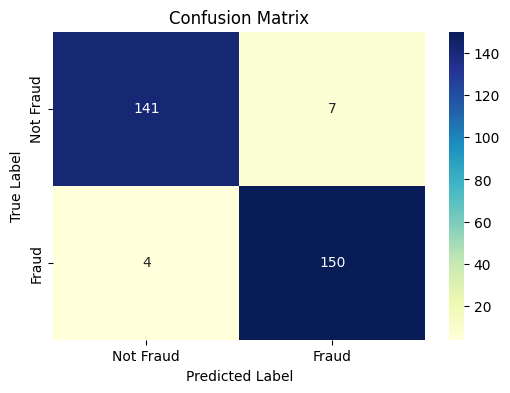

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu", xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
